# Load modules

In [1]:
from numpy import *
import seaborn as sns
import matplotlib.pyplot as plt

from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import FlatLambdaCDM
# Defining cosmology in use
# H0 = 0.68, Omega_m = 0.31
cosmo = FlatLambdaCDM(H0=68, Om0=0.31)

from astropy import coordinates
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord, Distance, match_coordinates_sky, cartesian_to_spherical, spherical_to_cartesian
from astropy.stats import median_absolute_deviation
from astropy.table import Table, vstack

from scipy.interpolate import interp1d
from scipy.stats import uniform, norm, linregress
from scipy.optimize import curve_fit

import tqdm

In [2]:
# Installing feature that reads mask file in .ply (uncomment if necessary)
#!pip install pymangle==0.9.1
#import pymangle

In [3]:
# Install and import HDBSCAN, used for galaxy membership
!pip install hdbscan
import hdbscan

# Install and import KneeLocator, used to locate the galaxy
# density drop, Rc, in the cluster
!pip install kneed
from kneed import KneeLocator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 13.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039191 sha256=303ba8d5d2de67e1953387fc643c4ee81292f0806528578129796be507610fd2
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan


# AME

## select galaxies

In [4]:
'''
# Given the cluster data, galaxy data, radius, redshift limits
# select galaxies within z_cl +/- Delta_z * (1 + z_cl), and R < radius
# return: astropy.Table with selected galaxies
'''

def select_galaxies(detcl, data, radius, dz):
  # cluster redshift
  cluster_redshift = detcl['z']

  # galaxies within cluster redshift
  cond = abs(data['z'] - cluster_redshift) < dz*(1+cluster_redshift)
  data_cut = data[cond]

  # distances between cluster and galaxies coordinates:
  c_detec = SkyCoord(detcl['ra'], detcl['dec'], unit='deg')
  c_data = SkyCoord(data_cut['ra'], data_cut['dec'], unit='deg')

  # SkyCoord.separation: The separation is calculated using the Vincenty formula
  sep = c_data.separation(c_detec)
  sep_kpc = array(tan(sep.radian)*cosmo.angular_diameter_distance(cluster_redshift).to(u.kpc))

  # select galaxies inside radius
  good_r = (sep_kpc>0) & (sep_kpc < radius)
  data_cut = data_cut[good_r]

  return data_cut

In [5]:
'''
# Given the cluster data, galaxy data, radius
# select galaxies within R < radius
# return: astropy.Table with selected galaxies
'''

def select_galaxies_radius(detcl, data, radius):
  # distances between cluster and galaxies coordinates:
  c_detec = SkyCoord(detcl['ra'], detcl['dec'], unit='deg')
  c_data = SkyCoord(data['ra'], data['dec'], unit='deg')

  # SkyCoord.separation: The separation is calculated using the Vincenty formula
  sep = c_data.separation(c_detec)
  sep_kpc = array(tan(sep.radian)*cosmo.angular_diameter_distance(detcl['z']).to(u.kpc))

  # select galaxies inside radiusin kpc
  good_r = (sep_kpc>0) & (sep_kpc < radius)
  data_cut = data[good_r]

  return data_cut

In [6]:
"""
# Given the cluster data, galaxy data, radius
# select galaxies within z_cl +/- Delta_z * (1 + z_cl), and R < radius
# return: astropy.Table with selected galaxies
"""
# selecting galaxies within z_cl +/- \Delta_z, and radius from cluster center < 1.5 Mpc
def select_galaxies_data(data, cluster_catalog, outer_radius, dz):
  r = kpc_to_degree(outer_radius, cluster_catalog['z'])
  cond_ra = (data['ra'] > cluster_catalog['ra'] - (r+r/10) ) & (data['ra'] < cluster_catalog['ra'] + (r+r/10) )
  cond_dec= (data['dec'] > cluster_catalog['dec'] - (r+r/10) ) & (data['dec'] < cluster_catalog['dec'] + (r+r/10) )
  cond_z  = (data['z'] > cluster_catalog['z']-5*dz*(1+cluster_catalog['z']) ) & (data['z'] < cluster_catalog['z']+5*dz*(1+cluster_catalog['z']) )
  data_cut = data[cond_ra & cond_dec & cond_z]

  return data_cut

## random redshift

In [7]:
'''
# Given a galaxy catalog and redshift array on which PDFs were estimated
# Generate a random redshift value from galaxy probability density function PDF(z)
# return: random redshift
'''

def random_redshift(data_cut, z):

  # for each galaxy draw a random value
  random_z = []
  for gal in range(len(data_cut)):
    #random value from distribution (uses normilized PDF)
    random_zi = random.choice(z, p=data_cut['PDF'][gal]/sum(data_cut['PDF'][gal]))
    random_z += [random_zi]

  return random_z

## peculiar velocity

In [8]:
'''
# Given cluster data, galaxy random redshift
# calculates the galaxies peculiar velocity
# return: peculiar velocity
'''

def peculiar_velocity(detcl, z):
  # cluster redshift
  z_cl = detcl

  # galaxy peculiar velocity
  v_gal = const.c.to('km/s').value * (z - z_cl) / (1 + z_cl)

  return v_gal

## velocity dispersion

In [9]:
'''
# Given galaxy velocity, n sigma clipping
# calculates the velocity dispersion
# return: mean velocity, dispersion
'''

def velocity_dispersion_3sigma(v_gal, n):

  # For sigma clipping
  # initial median value galaxies peculiar velocity
  v_mean_i = 1
  # median value
  v_mean = mean(v_gal)
  # standard deviation
  sigma_cl = std(v_gal)

  # while difference greater than 1e-5
  i = 0
  while abs((v_mean - v_mean_i) / v_mean_i) > 1e-5:
    # clipping condition
    cond = abs(v_gal-v_mean) < n*sigma_cl
    # new values
    v_gal = v_gal[cond]
    v_mean_i = v_mean
    v_mean = mean(v_gal)
    sigma_cl = std(v_gal)
    # counter
    i=i+1

  return v_mean, sigma_cl

## HDBSCAN label check

In [10]:
'''
# Given HDBSCAN.unique_labels, HDBSCAN.clusterer_probs, galaxy data, cluster
# if identified more than one label, identify the set closest to the cluster center
# return: HDBSCAN.unique_labels closest to the cluster center
'''

def label_check(unique_labels, clusterer_probs, data_cut, cluster):

  # saves the mean distance from mnultiple labels
  dist_check = []

  # possible labels (introduce more if needed)
  b2 = [0,1,2,3,4,5]

  # from the galaxy identification labels creates array with one value each
  unique_labels_check = array(list(set(unique_labels).intersection(b2)))

  if len(unique_labels_check) > 1:

    # distances between cluster and galaxies coordinates:
    c_detec = SkyCoord(cluster['ra'],cluster['dec'], unit='deg')
    c_data = SkyCoord(data_cut['ra'],data_cut['dec'], unit='deg')

    # SkyCoord.separation: The separation is calculated using the Vincenty formula
    sep = c_data.separation(c_detec)
    sep_kpc = array(tan(sep.radian)*cosmo.angular_diameter_distance(data_cut['random_z']).to(u.kpc))
    data_cut['sep_kpc'] = sep_kpc

    # for each galaxy label, calculate median distances
    for ij in range(len(unique_labels_check)):
      dist_check += [(mean(data_cut['sep_kpc'][unique_labels == unique_labels_check[ij]]),ij)]

    # label with minimum distance
    cond_label = unique_labels == min(dist_check)[1]

  else: cond_label = unique_labels == 0

  return cond_label

## hbdscan run

In [11]:
'''
# Given a galaxies catalog, a cluster, redshift width, enclosed radius, number of .
# runs (default = 100), parameters from relation true members x FAE richness (gradient, intercept),
# FAE richness, define is_mock = 0, do_plot=0, do_prints=0, do_print_stats=0 (0 = false, 1 = true)
# the galaxies probabilities HDBSCAN.clusterer_probs
# return: mean coordinates, redshift, distance from new center, rich as sum(HDBSCAN.clusterer_probs)
'''

def hbdscan_run(data, cluster, dz, radius, N_runs, gradient, intercept, cluster_rich,
                is_mock=0, do_plot=0):

  # cluster identification
  c_data = SkyCoord(data['ra'],data['dec'], unit='deg')
  c_detec = SkyCoord(cluster['ra'],cluster['dec'], unit='deg')

  # selecting galaxies within radius
  data_cut = select_galaxies_radius(cluster, data, radius)

  # Mock memebership
  if is_mock==1:
    # cluster id
    cond_id = cluster['haloId']
    # creates a column in galaxy catalog and assign membership as 1
    data['member'] = [0]*len(data)
    data['member'][data['haloId']==cond_id] = 1

  # Control data for membership analysis (data within Rc and dz)
  data_cut_control = data_cut
  cond = abs(data_cut_control['z']-cluster['z']) < dz
  data_cut_control = data_cut_control[cond]

  # creates a column for HDBSCAN probabilities
  data_cut_control['member_ame'] = [0.]*len(data_cut_control)

  # Galaxy identification ids
  gal_num2 = []

  # Number of expected galaxies HDBSCAN.min_cluster_size. Must be an integer!
  # depends on the cluster FAE richness, comes from simulation data.
  cluster_size_f =  gradient*cluster_rich+intercept
  # limit to be considered a valid detection
  # comes from std FAE richness applied in random coordinates
  # If cluster size is lower than 2, fixes it in 2
  if (cluster_size_f>=0.6) & (cluster_size_f<2): cluster_size = 2
  else:  cluster_size = int(cluster_size_f)

  if cluster_size > 1:
    # if no galaxies found in around cluster center
    if len(data_cut_control)==0: print('no galaxies within Rc')

    # number of repetitions for probability estimate
    for j in range(N_runs):

      # estimating a random redshift value with PDFs
      data_cut['random_z'] = random_redshift(data_cut, zs)

      # Compute peculiar velocity and select galaxies
      data_cut['vp'] = peculiar_velocity(cluster['z'], data_cut['random_z'])

      # Mean velocity to remove galaxies with sigma_v > 3sigma
      v_mean, sigma = velocity_dispersion_3sigma(data_cut['vp'], 3)

      # If we have enough galaxies after cuts, else: nan
      if len(data_cut[abs(data_cut['vp']-v_mean) < 3*sigma])>1:
        data_cut = data_cut[abs(data_cut['vp']-v_mean) < 3*sigma]

        # Generates HDBSCAN format sample data
        X2 = []
        for i in range(len(data_cut)):
          X2 += [[(data_cut['ra'][i]-cluster['ra']),
                  data_cut['dec'][i]-cluster['dec']]]
        X2 = array(X2)

        # Run HDBSCAN allowing a single custer
        clusterer = hdbscan.HDBSCAN(min_cluster_size=cluster_size,
                                    gen_min_span_tree=True,
                                    allow_single_cluster=True)
        clusterer.fit(X2)

        # Plotting results
        if do_plot ==1:
          # Plot cluster members
          plt.scatter(X2.T[0], X2.T[1], color='k')
          palette = sns.color_palette("husl", 9)
          cluster_colors = [sns.desaturate(palette[col], sat)
                            if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                            zip(clusterer.labels_, clusterer.probabilities_)]
          plt.scatter(X2.T[0], X2.T[1], c=cluster_colors)
          if is_mock == 1:
            plt.plot(data_cut_control['ra'][data_cut_control['member']==1]-cluster['ra'],
                    data_cut_control['dec'][data_cut_control['member']==1]-cluster['dec'],
                    'o', markerfacecolor='none', color='k', ms=10, label='true member')
            plt.plot(X2.T[0][data_cut['member']==1], X2.T[1][data_cut4['member']==1],
                    'o', markerfacecolor='none', color='cyan', ms=10, label='selected true member')
          plt.legend()
          plt.show()

        # Take only the bunch of galaxies closest to the cluster center
        cond_label = label_check(clusterer.labels_, clusterer.probabilities_,
                                 data_cut, cluster)

        # Saves galaxy ids for further count
        for i1 in range(len(data_cut['ID'][cond_label])):
          gal_num2.append(data_cut['ID'][cond_label][i1])


  # Counts how many times a galaxy apears as a cluster member
  Prob = []
  for l in data_cut_control['ID']:
    Prob += [gal_num2.count(l)/N_runs]

  # Save probability into the data
  data_cut_control['member_hdbsdcan'] = Prob
  data['clusterID'][list(data_cut_control['l_id'])] = cluster['ID']
  data['Prob'][list(data_cut_control['l_id'])] = Prob

  # Saves mock galaxies within Rc
  if is_mock==1: data['mem'][list(data_cut_control['l_id'])] = mem

  return data_cut_control


import warnings
warnings.filterwarnings("ignore")

## random catalog

In [12]:
'''
# Given a redshift value (or array), and data catalog (ra, dec)
# creates an astropy.Table with random coordinates, and selected zs
# define table size, if redshift array: must be of the same size
# return: random coordinates catalog
'''

def random_catalog(zs, catalog, size = 50):

  random_detec = Table()

  # generate random positions
  if type(zs) == ndarray: random_detec['z'] = zs
  else: random_detec['z'] = [zs]*size
  random_detec['ra'] = random.uniform(low=min(catalog['ra']),  high=max(catalog['ra']),  size=size)
  random_detec['dec']= random.uniform(low=min(catalog['dec']), high=max(catalog['dec']), size=size)
  random_detec['ID'] = arange(len(random_detec))
  # if using .ply mask, uncomment next lines
  #npoins = 50
  #good_m = m.contains(random_detec['ra'], random_detec['dec'])
  #random_detec=random_detec[good_m][:npoins]
  # verify if final catalog has enough points after mask
  #if len(random_detec) < npoins: print('catalog length lower than %d'%npoins)

  return random_detec


## updated version for large datasets

In [13]:
'''
# Updated version for large datasets
'''

def hbdscan_run_bigdata(data, cluster, dz, radius, N_runs, gradient, intercept, cluster_rich, do_plot=0):

  # cluster identification
  c_data = SkyCoord(data['ra'], data['dec'], unit='deg')
  c_detec = SkyCoord(cluster['ra'], cluster['dec'], unit='deg')

  # selecting galaxies within radius
  data_cut = select_galaxies_radius(cluster, data, radius)

  # Control data for membership analysis (data within Rc and dz)
  data_cut_control = data_cut
  cond = abs(data_cut_control['z']-cluster['z']) < dz
  data_cut_control = data_cut_control[cond]

  # Galaxy identification ids
  gal_num2 = []
  gal_num_sub = []

  # Number of expected galaxies HDBSCAN.min_cluster_size. Must be an integer!
  # depends on the cluster FAE richness, comes from simulation data.
  cluster_size_f =  gradient*cluster_rich+intercept

  # limit to be considered a valid detection
  # comes from std FAE richness applied in random coordinates
  # If cluster size is lower than 2, fixes it in 2
  if (cluster_size_f>=0.6) & (cluster_size_f<2): cluster_size = 2
  else:  cluster_size = int(cluster_size_f)

  if cluster_size > 1:
    # if no galaxies found in around cluster center
    if len(data_cut_control)==0: print('no galaxies within Rc')

    # number of repetitions for probability estimate
    for j in range(N_runs):

      # estimating a random redshift value with PDFs
      data_cut_z = data_cut
      data_cut_z['random_z'] = random_redshift(data_cut, zs)

      # Apply redshift cut
      cond = abs(data_cut_z['random_z']-cluster['z']) < dz
      data_cut4 = data_cut_z[cond]

      # Compute peculiar velocity and select galaxies
      data_cut4['vp'] = peculiar_velocity(cluster['z'], data_cut4['random_z'])

      # Mean velocity to remove galaxies with sigma_v > 3sigma
      v_mean, sigma = velocity_dispersion_3sigma(data_cut4['vp'], 3)

      # If we have enough galaxies after cuts, else: nan
      if len(data_cut4[abs(data_cut4['vp']-v_mean) < 3*sigma])>1:
        data_cut4 = data_cut4[abs(data_cut4['vp']-v_mean) < 3*sigma]

        # Generates HDBSCAN format sample data
        X2 = []
        for i in range(len(data_cut4)):
          X2 += [[(data_cut4['ra'][i]-cluster['ra']),
                  data_cut4['dec'][i]-cluster['dec']]]
        X2 = array(X2)

        # Run HDBSCAN allowing a single custer
        clusterer = hdbscan.HDBSCAN(min_cluster_size=cluster_size,
                                    gen_min_span_tree=True,
                                    allow_single_cluster=True)
        clusterer.fit(X2)

        # Plotting results
        if do_plot ==1:
          # Plot cluster members
          plt.scatter(X2.T[0], X2.T[1], color='k')
          palette = sns.color_palette("husl", 9)
          cluster_colors = [sns.desaturate(palette[col], sat)
                            if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                            zip(clusterer.labels_, clusterer.probabilities_)]
          plt.scatter(X2.T[0], X2.T[1], c=cluster_colors)
          if is_mock == 1:
            plt.plot(data_cut_control['ra'][data_cut_control['member']==1]-cluster['ra'],
                    data_cut_control['dec'][data_cut_control['member']==1]-cluster['dec'],
                    'o', markerfacecolor='none', color='k', ms=10, label='true member')
            plt.plot(X2.T[0][data_cut4['member']==1], X2.T[1][data_cut4['member']==1],
                    'o', markerfacecolor='none', color='cyan', ms=10, label='selected true member')
            plt.legend()
          plt.show()

        # Take only the bunch of galaxies closest to the cluster center
        cond_label = label_check(clusterer.labels_, clusterer.probabilities_,
                                 data_cut4, cluster)[0]

        # Saves galaxy ids for further count
        for i1 in range(len(data_cut4['ID'][cond_label])):
          gal_num2.append(data_cut4['ID'][cond_label][i1])


  # Counts how many times a galaxy appears as a cluster member
  Prob = []
  for l in data_cut_control['ID']:
    Prob += [gal_num2.count(l)/N_runs]

  # Save probability into the data
  data_cut_control['Prob'] = Prob
  data_cut_control['cluster_ID'] = cluster['ID']

  return data_cut_control

# FAE

## Richness code

In [14]:
'''
# Given a galaxy catalog, cluster catalog, redshift width, enclosed radius,
# field galaxies density function (popt_mode, popt_err)
# estimate richness as the sum of the galaxy probability of being at the cluster z +/- dz
# return: richness, err, snr
'''

def richness_rv(data, detections, deltaz, radius, popt_mode, popt_err):

  #cluster redshift
  cluster_redshift = detections['z']

  #distances between cluster and galaxies:
  c_data = SkyCoord(data['ra'],data['dec'], unit='deg')
  c_detec = SkyCoord(detections['ra'],detections['dec'], unit='deg')

  #SkyCoord.separation: The separation is calculated using the Vincenty formula
  sep = c_data.separation(c_detec)
  sep_kpc = array(tan(sep.radian)*cosmo.angular_diameter_distance(cluster_redshift).to(u.kpc))

  if len(sep[sep_kpc < radius])>0:
    #select galaxies inside radius
    good_r = (sep_kpc > 0) & (sep_kpc < radius)
    data_cut = data[good_r]

    # test coordinates againts mask/borders, estimate cluster area
    cluster_area = area_outside_mask(c_detec, cluster_redshift, radius)

    #redshift limits
    zlim = [cluster_redshift - deltaz*(1.+cluster_redshift), cluster_redshift + deltaz*(1.+cluster_redshift)]

    #Galaxies probabilities within zlim
    prob = prob_calc(data_cut, zs, zlim)

    # estimate richness, err, snr given the field galaxies
    rich = sum(prob) - cluster_area[0]*func(cluster_redshift, *popt_mode)
    err = sqrt(sum(prob) + (cluster_area[0]*func(cluster_redshift, *popt_err))**2)
    if rich < 0: snr = 0
    else: snr = (rich/err)**2

  # if no galaxies within the cluster center
  else:
    rich = 0
    err = 0
    snr = 0

  return rich, err, snr

## probability calculation

In [15]:
'''
# Given galaxy data, redshift array on which PDFs were estimated and redshift limits
# calculates the probability of membership of a galaxy inside a redshift limit.
# return: an array of probabilities
'''
def prob_calc(data_cut, z, zlim):
  # final probability array
  prob=[]

  for gal in range(len(data_cut)):

    # calculating cdf from pdf
    pdf = data_cut[gal]['PDF']
    cdf = cumsum(pdf)
    cdf = cdf/cdf[-1]

    #cdf interpolation
    f0 = interp1d(z,cdf)

    #function values in the z limits
    if zlim[0] < z[0]: prob_x1=0
    else: prob_x1 = f0(zlim[0])
    if zlim[1] < z[0]: prob_x2=0
    elif zlim[1] > z[-1]: prob_x2 = f0(z[-1])
    else: prob_x2 = f0(zlim[1])

    # prob = cdf(x2)-cdf(x1)
    prob += [prob_x2 - prob_x1]

  return array(prob)

## kpc to degree

In [16]:
'''
# Given radius in kpc, and redshift
# calculates the radius in degrees
# return: radius in degrees
'''

def kpc_to_degree(radius,redshift):
	return degrees(arctan(radius/cosmo.angular_diameter_distance(redshift).to(u.kpc).value))

## area outside mask

In [17]:
'''
# Given cluster coordinates (x_center, y_center), redshift, and enclosed radius
# creates a distribuition of N points inside the radius and test againts mask
# return: corresponding area outside the mask region.
'''

def area_outside_mask(cluster_coordinates, cluster_redshift, r_ring_max, r_ring_min=0):
  #number of random points
  N = 2500

  #centering coordinates
  x_center = cluster_coordinates.ra.value
  y_center = cluster_coordinates.dec.value

  #circular distribuition of points
  ra = []
  dec= []

  r = kpc_to_degree(r_ring_max, cluster_redshift)

  for i in range (0,N):
    theta = 2*pi*random.random()
    eta_sqrt = sqrt(random.random())
    rad = 2*r*eta_sqrt
    ra.append(x_center + rad*cos(theta))
    dec.append(y_center + rad*sin(theta))

  ra = array(ra)
  dec= array(dec)

  #test arrays of ra,dec points against box boundaries
  c_data = SkyCoord(ra, dec, unit='deg')

  #SkyCoord.separation: The separation is calculated using the Vincenty formula
  sep = c_data.separation(cluster_coordinates)
  sep_kpc = array(tan(sep.radian)*cosmo.angular_diameter_distance(cluster_redshift).to(u.kpc))

  # inside enclosed radius
  good_rmax = (sep_kpc < r_ring_max)
  # if minimum is required
  good_rmin = (sep_kpc > r_ring_min)

  # box boundaries (max/min of the galaxies coordinates)
  # if .ply mask use simply: good_m = m.contains(ra, dec)
  good_ra_max = (ra < maxra)
  good_ra_min = (ra > minra)
  good_dec_max = (dec < maxdec)
  good_dec_min = (dec > mindec)
  good_m = good_ra_max & good_ra_min & good_dec_max & good_dec_min


  good2 = good_m & good_rmax & good_dec_min

  # ring area
  circle_area = pi*r**2
  estimated_area = circle_area*len(ra[good2])/len(ra[good_rmax & good_dec_min])

  return estimated_area, ra[good2], dec[good2]

## field galaxies density

In [18]:
'''
# Given redshift of reference, radius, and galaxy catalog (ra, dec)
# Calculate the field density through the survey area
# define do_plot, if 0 = false, 1 = true
# return: density at redshift
'''

def var_redshift(redshift, radius, data, do_plot=0):
  # take radius in degrees
  radius_degree = degrees(arctan(radius/cosmo.angular_diameter_distance(redshift).to(u.kpc).value))

  # define a step proportional to cluster area
  step = radius_degree*sqrt(pi)
  step_ra = degrees(radians(step)/cos(radians(median(data['dec']))))

  # devide survey area
  ra_lim = arange(min(data['ra'])-step_ra/2, max(data['ra']), step_ra)
  dec_lim= arange(min(data['dec'])-step/2, max(data['dec']), step)

  #redshift limits
  deltaz = 0.05
  zlim = [redshift-deltaz*(1.+redshift), redshift+deltaz*(1.+redshift)]

  # use largers steps if the survey area is large
  if redshift < 0.1: step2 = 2
  if redshift < 0.2: step2 = 4
  if redshift < 0.3: step2 = 6
  if redshift < 0.4: step2 = 8
  else: step2 = 3

  N_gal,tot_area=[], []

  # plot galaxies
  if do_plot==1: plt.plot(data['ra'], data['dec'], '.')

  # for each smaller area
  for i in range(1, len(ra_lim), step2):
    for j in range(1, len(dec_lim), step2):
      # coordinate limits
      cond_ra  = (abs(data['ra'] - ra_lim[i]) < step_ra/2)
      cond_dec = (abs(data['dec'] - dec_lim[j]) < step/2)
      # select data within limits
      data_cut = data[cond_ra & cond_dec]
      # calculate number of galaxies within dz and area
      N_gal += [sum(prob_calc(data_cut, zs, zlim))]
      tot_area += [step_ra*step]

      if do_plot==1: plt.plot(data['ra_rot'][cond_ra & cond_dec],data['dec_rot'][cond_ra & cond_dec],'.')

  if do_plot==1:
    plt.grid()
    plt.show()

  # calculate density
  N_gal, tot_area = array(N_gal), array(tot_area)
  cond = N_gal>0
  dens = N_gal[cond]/tot_area[cond]

  return array(dens[dens>1e-5])

In [19]:
# polinomial function for field density interpolation
def func(x, a, b, c, d, e):
    return a+b*x+c*x**2+d*x**3+e*x**4#+f*x**5

In [20]:
'''
# Given enclosed radius, galaxy catalog, stats name
# calculates the the 3 sigma statistics with density
# saves the final result for future use, define do_plot=1 0=false, 1=true
# return: interpolation result (popt_mode, popt_err)
'''

def survey_area_statistics(radius_att, data, stats, do_plot=1):
  # redshift range
  z = arange(.04,.5,.05)

  # array
  mode = []
  err = []

  for k in tqdm.tqdm(range(len(z))):
    # calculate the field density
    tot_dens = var_redshift(z[k], radius_att, data)
    # for plotting initial array
    if do_plot==1: tot_dens2 = tot_dens

    # initial value for 3 sigma clipping
    median2 = 1
    while abs((median(tot_dens)-median2)/median2) > 0.002:
      std_v = median_absolute_deviation(tot_dens)
      # iterate initial value
      median2 = median(tot_dens)
      # cut condition
      cond = (tot_dens > median(tot_dens)-3*std_v) & (tot_dens < median(tot_dens)+3*std_v)
      # final value
      tot_dens = tot_dens[cond]

    # calculate median density value
    mode += [median(tot_dens)]
    # err
    err += [median_absolute_deviation(tot_dens)]

    if do_plot==1:
      plt.title('z=%.3f ~ n quadrados:%d'%(z[k],len(tot_dens)))
      plt.axvline(mode[k], ls=':',color='k')
      bins = histogram(hstack((tot_dens2,tot_dens)), bins=150)[1]
      plt.hist(tot_dens2, bins = bins)
      plt.hist(tot_dens, bins = bins)
      plt.xlabel('N_gal/area')
      plt.ylabel('Counts')
      plt.show()

  # interpolation
  popt_mode, pcov_mode = curve_fit(func, z, mode)
  popt_err, pcov_err = curve_fit(func, z, err)

  #writing to file
  z, mode, err = array(z), array(mode), array(err)
  out    = transpose([z, mode, err])
  header = "z      median      err"
  savetxt('%s'%stats, out, fmt='%1.6e', header=header)

  if do_plot==1: # plot results
    plt.plot(z, mode, '.', label='median density')
    plt.plot(z, func(z,*popt_mode),':', label='density fit')

    plt.plot(z, err, '.', label='err')
    plt.plot(z, func(z,*popt_err),':', label='err fit')

    plt.xlabel('redshift')
    plt.ylabel('density counts/area')
    plt.title('Field contribution')
    plt.show()

  return popt_mode, popt_err


## updated version for large datasets

In [21]:
"""
# FAE updated version
# This version allows to take field galaxies along annulus to avoid counting
# density contribution along the entire galaxy dataset
# This version is also intresting for different apparent magnitude cuts
"""

def richness_bigdata(data, bg_data_cut, detections, deltaz, radius):

  #cluster redshift
  cluster_redshift = detections['z']

  #distances between cluster and galaxies:
  #galaxies and clusters coordinates
  c_data = SkyCoord(data['ra'], data['dec'], unit='deg')
  c_detec = SkyCoord(detections['ra'], detections['dec'], unit='deg')

  #SkyCoord.separation: The separation is calculated using the Vincenty formula
  sep = c_data.separation(c_detec)
  sep_kpc = array(tan(sep.radian)*cosmo.angular_diameter_distance(cluster_redshift).to(u.kpc))

  #select galaxies inside radius
  good_r = (sep_kpc < radius) & (sep_kpc >= 0)
  data_cut = data[good_r]

  #redshift limits
  zlim = [cluster_redshift-deltaz*(1.+cluster_redshift),
          cluster_redshift+deltaz*(1.+cluster_redshift)]

  #Galaxies probabilities
  prob=prob_calc(data_cut, zs, zlim)

  #background correction-----------------
  #select galaxies inside ring radius
  r_ring_min = 3 * radius
  r_ring_max = 5 * radius

  #SkyCoord.separation: The separation is calculated using the Vincenty formula
  c_data_bg = SkyCoord(bg_data_cut['ra'], bg_data_cut['dec'], unit='deg')
  sep_bg = c_data_bg.separation(c_detec)
  sep_kpc_bg = array(tan(sep_bg.radian)*cosmo.angular_diameter_distance(cluster_redshift).to(u.kpc))

  bg_r_max = (sep_kpc_bg < r_ring_max)
  bg_r_min = (sep_kpc_bg > r_ring_min)

  bg_data_cut = bg_data_cut[bg_r_min & bg_r_max]

  if len(bg_data_cut)>0:
    #area ra dec
    bg_area = area_outside_mask_ring_bigdata(c_detec, cluster_redshift, r_ring_max, r_ring_min)

    #Divide in 8 parts: removes the ones with higher and lower counts
    steps=8

    theta_data = arctan2(bg_data_cut['dec'] - c_detec.dec.value,
                         bg_data_cut['ra'] - c_detec.ra.value)*180/pi
    theta_mc = arctan2(bg_area[2] - c_detec.dec.value,
                       bg_area[1] - c_detec.ra.value)*180/pi
    area_tmc = bg_area[0]
    delta_theta= (max(theta_data)-min(theta_data))/steps

    rich_med=[]
    for i in range(steps):
      #background probabilities
      cond_c1 = (theta_data > min(theta_data)+i*delta_theta) & (theta_data<min(theta_data)+(i+1)*delta_theta)
      bg_prob = prob_calc(bg_data_cut[cond_c1], zs, zlim)

      ra_sector = bg_data_cut['ra'][ cond_c1]
      dec_sector= bg_data_cut['dec'][cond_c1]

      cond_c2 = (theta_mc > min(theta_data)+i*delta_theta) & (theta_mc<min(theta_data)+(i+1)*delta_theta)
      ra_mc = bg_area[1][cond_c2]
      dec_mc= bg_area[2][cond_c2]

      if len(bg_prob) > 0:
        area_data = area_tmc*len(ra_mc)/len(bg_area[1])
        rich_med.append(sum(bg_prob)/area_data)

    filtered_data = sigma_clip(rich_med, sigma=2)

  else: filtered_data = 0

  #Area calculation with masks
  cluster_area = area_outside_mask_bigdata(c_detec, cluster_redshift, radius)

  #richness is the sum of all probabilities - prob background galaxies*cluster_area/bg_area
  rich = sum(prob) - mean(filtered_data)*cluster_area[0]

  return rich



In [22]:

def area_outside_mask_ring_bigdata(cluster_coordinates, cluster_redshift, r_ring_max, r_ring_min):
  #number of random points
  N = 10000

  #centering coordinates
  x_center = cluster_coordinates.ra.value
  y_center = cluster_coordinates.dec.value

  #circular distribuition of points
  ra = []
  dec= []

  r = kpc_to_degree(r_ring_max, cluster_redshift)
  for i in range (0,N):
    theta = 2*pi*random.random()
    eta_sqrt = sqrt(random.random())
    rad = 2*r*eta_sqrt
    ra.append(x_center + rad*cos(theta))
    dec.append(y_center + rad*sin(theta))

  ra = array(ra)
  dec= array(dec)

  #test arrays of ra,dec points against box boundaries
  good_ra_max = (ra <  maxra)
  good_ra_min = (ra > minra)
  good_dec_max = (dec < maxdec)
  good_dec_min = (dec > mindec)
  c_data = SkyCoord(ra,dec, unit='deg')

  #SkyCoord.separation: The separation is calculated using the Vincenty formula
  sep = c_data.separation(cluster_coordinates)
  sep_kpc = array(tan(sep.radian)*cosmo.angular_diameter_distance(cluster_redshift).to(u.kpc))

  #test arrays of ra,dec points against the mask
  good_rmax = (sep_kpc < r_ring_max)
  good_rmin= (sep_kpc > r_ring_min)

  good2= good_rmax & good_rmin & good_ra_max & good_ra_min & good_dec_max & good_dec_min

  #ring area
  circle_area = pi*r**2

  #print('cluster area:',circle_area)
  estimated_area = circle_area*len(ra[good2])/len(ra[good_rmax])

  return estimated_area, ra[good2], dec[good2]


In [23]:

def area_outside_mask_bigdata(cluster_coordinates, cluster_redshift, r_ring_max, r_ring_min=0):
  #number of random points
  N = 5000

  #centering coordinates
  x_center = cluster_coordinates.ra.value
  y_center = cluster_coordinates.dec.value

  #circular distribuition of points
  ra = []
  dec= []

  r = kpc_to_degree(r_ring_max, cluster_redshift)

  for i in range (0,N):
    theta = 2*pi*random.random()
    eta_sqrt = sqrt(random.random())
    rad = 2*r*eta_sqrt
    ra.append(x_center + rad*cos(theta))
    dec.append(y_center + rad*sin(theta))

  ra = array(ra)
  dec= array(dec)

  #test arrays of ra,dec points against box boundaries
  c_data = SkyCoord(ra, dec, unit='deg')

  #SkyCoord.separation: The separation is calculated using the Vincenty formula
  sep = c_data.separation(cluster_coordinates)
  sep_kpc = array(tan(sep.radian)*cosmo.angular_diameter_distance(cluster_redshift).to(u.kpc))

  # inside enclosed radius
  good_rmax = (sep_kpc < r_ring_max)
  # if minimum is required
  good_rmin = (sep_kpc > r_ring_min)

  # box boundaries (max/min of the galaxies coordinates)
  # if .ply mask use simply: good_m = m.contains(ra, dec)
  good_ra_max = (ra <  maxra)
  good_ra_min = (ra > minra)
  good_dec_max = (dec < maxdec)
  good_dec_min = (dec > mindec)
  good_m = good_ra_max & good_ra_min & good_dec_max & good_dec_min


  good2 = good_m & good_rmax & good_dec_min

  # ring area
  circle_area = pi*r**2
  estimated_area = circle_area*len(ra[good2])/len(ra[good_rmax & good_dec_min])

  return estimated_area, ra[good2], dec[good2]

# Rc

In [24]:
'''
# Given a galaxies catalog, and a cluster (ra, dec, z)
# find the density break in the radial galaxy density profile
# define do_plot, if 0 = false, 1 = true
# return: Rc
'''

def radial_density_knee(data_cut, cluster, plot=0):
  # radial density break
  knee = []

  # cilinder depth
  # Select galaxies around cluster center
  dz = 0.05
  outer_radius = 1500 #kpc
  data_cut = select_galaxies(cluster, data_cut, outer_radius, dz)

  hc = 2*dz*(1+cluster['z'])

  # data coordinates
  c_data = SkyCoord(data_cut['ra'],data_cut['dec'], unit='deg')
  c_detec = SkyCoord(cluster['ra'],cluster['dec'], unit='deg')

  # Distance between cluster center and galaxy coordinates
  sep = c_data.separation(c_detec)
  sep_kpc = array(tan(sep.radian)*cosmo.angular_diameter_distance(cluster['z']).to(u.kpc))
  #data_cut['sep_kpc'] = sep_kpc

  # anulus radius
  r1gas = 450.
  n = 20
  rmaxgas = 5000
  logdrgas = (log10(rmaxgas/r1gas))/n
  rgas = sep_kpc

  x1=[]	# radius
  y1=[]	# density

  A1 = 0

  # test against borders
  r = kpc_to_degree(outer_radius, cluster['z'])
  good_ra_max = (max(data_cut['ra'])+r < maxra )
  good_ra_min = (min(data_cut['ra'])-r > minra )
  good_dec_max = (max(data_cut['dec'])+r < maxdec)
  good_dec_min = (min(data_cut['dec'])-r > mindec)

  if good_ra_max & good_ra_min & good_dec_max & good_dec_min:
    A2 = pi*r1gas**2

    while r1gas < outer_radius:
      r2gas=10**(log10(r1gas)+logdrgas)	#iteracao de r2

      # measures cilinder volume
      A1 = pi*r2gas**2
      v1 = (A1-A2)*hc**2
      A2 = A1

      # selec data inside radius data conditions
      cond = argwhere( (rgas>=r1gas) & (rgas<=r2gas) ).flatten()
      Rhogas=len(data_cut[cond])/v1
      rgas1=(r1gas+r2gas)/2.

      # Ensures a valid density
      if Rhogas > 0:
        y1.append(Rhogas)
        x1.append(rgas1)

      step = 10
      r1gas= r1gas + step

  else:
    A2 = area_outside_mask(c_detec, cluster['z'], r1gas)[0]

    while r1gas < outer_radius:
      r2gas=10**(log10(r1gas)+logdrgas)	#iteracao de r2

      # measures cilinder volume
      A1 = area_outside_mask(c_detec, cluster['z'], r2gas)[0]
      v1 = (A1-A2)*hc**2
      A2 = A1

      # selec data inside radius data conditions
      cond = argwhere( (rgas>=r1gas) & (rgas<=r2gas) ).flatten()
      Rhogas=len(data_cut[cond])/v1
      rgas1=(r1gas+r2gas)/2.

      # Ensures a valid density
      if Rhogas > 0:
        y1.append(Rhogas)
        x1.append(rgas1)

      step = 10
      r1gas= r1gas + step		# next step

  # takes as a knee a convex curve, decreasing.
  # skips first value
  if len(x1)> 0:
    kneedle = KneeLocator(x1[1:], y1[1:], curve="convex", direction="decreasing")
    knee = kneedle.knee
  else: knee = 450.
  if knee is None: knee = 450.

  if plot == 1:
    #plt.title('%d'%len(data_cut[data_cut['member']== 1]))
    plt.axvline(kneedle.knee,ls=':',color='b', label='%.2f'%kneedle.knee)
    plt.semilogy(x1,y1,'.-', color='k',alpha=1)
    plt.legend()
    plt.show()

  return knee

# Run

In [25]:
'''
# Given the cluster catalog, galaxy catalog, catalog name, initial iteration
# calculate cluster_catalog probabilities and subproducts as richness and optical luminosity
# return: cluster_catalog Table with memberships, and subproducts
'''

def run(cluster_catalog, data2, catalog_name, init=0):
  #-----------------------------------
  if init ==0:
    # data new columns for code
    data2['l_id'] =  arange(len(data2))
    data2['Prob'] =  [99.9]*len(data2)
    data2['clusterID'] =  [99.9]*len(data2)

    # catalog new columns
    #cluster_catalog['knees'] = [99.9]*len(cluster_catalog)
    cluster_catalog['R_fae'] = [99.9]*len(cluster_catalog)
    cluster_catalog['R_fae_err'] = [99.9]*len(cluster_catalog)
    cluster_catalog['R_ame'] = [99.9]*len(cluster_catalog)
    cluster_catalog['R_ame_err'] = [99.9]*len(cluster_catalog)
    cluster_catalog['opt_lum'] = [99.9]*len(cluster_catalog)
    cluster_catalog['opt_lum_err'] = [99.9]*len(cluster_catalog)
    #cluster_catalog['opt_mass_hdbs'] = [99.9]*len(cluster_catalog)
    #cluster_catalog['opt_mass_hdbs_err'] = [99.9]*len(cluster_catalog)

  #-----------------------------------
  # init = reestart point if needed (default=0)
  for i in tqdm.tqdm(range(init, len(cluster_catalog))):

    # firts calculate knee radius (full galaxy data)
    knee = cluster_catalog['Rc'][i]

    # FAE --------
    deltaz = 0.05
    rich, err, snr = richness_rv(data2, cluster_catalog[i], deltaz, knee, popt_mode, popt_err)
    cluster_catalog['R_fae'][i] = rich

    # AME -------
    out_data = hbdscan_run(data2, cluster_catalog[i], 0.05, knee, 50, 0.5292105368716316,
                           0.026652401872489406, rich)

    # subproducts from probabilistic membership: richness, optical luminosity, ...
    cluster_catalog['R_ame'][i]     = sum(out_data['member_hdbsdcan'])
    cluster_catalog['opt_lum'][i]  = sum(out_data['member_hdbsdcan']*(10**(0.4*(4.42-out_data['M']))))
    #cluster_catalog['opt_mass_hdbs'][i] = sum(out_data['member_hdbsdcan']*out_data['stellar_mass']*10**10)

    # produce random catalog for error assignment
    size = 50
    random_detec2 = random_catalog(cluster_catalog[i]['z'], cluster_catalog, size)

    rich_r1, rich_r2 = [], []
    opt_lum_err, opt_mass_err = [] ,[]

    for ID_r in range(len(random_detec2)):
      rich, err, snr = richness_rv(data2, random_detec2[ID_r], deltaz, knee, popt_mode, popt_err)
      rich_r1 += [rich]

      data_cut = hbdscan_run(data2, random_detec2[ID_r], deltaz, knee, 50, 0.5292105368716316,
                             0.026652401872489406, rich)

      rich_r2 += [sum(data_cut['member_hdbsdcan'])]
      opt_lum_err += [sum(data_cut['member_hdbsdcan']*(10**(0.4*(4.42-data_cut['M']))))]
      #opt_mass_err += [sum(data_cut['member_hdbsdcan']*data_cut['stellar_mass']*10**10)]

    # Error is calculated as the standard error of the mean
    cluster_catalog['R_fae_err'][i] = std(rich_r1)/sqrt(len(rich_r1)-1)
    cluster_catalog['R_ame_err'][i] = std(rich_r2)/sqrt(len(rich_r1)-1)
    cluster_catalog['opt_lum_err'][i] = std(opt_lum_err)/sqrt(len(rich_r1)-1)
    #cluster_catalog['opt_mass_hdbs_err'][i] = std(opt_mass_err)

    if i%200 == 0: # temporary saving
      cluster_catalog.write('%s/%s_%s.fits'%(path, catalog_name, init), format='fits', overwrite=True)
      data2.write('%s/data_%s_%s.fits'%(path, catalog_name, init), format='fits', overwrite=True)

  # final saving
  cluster_catalog.write('%s/%s_%s.fits'%(path, catalog_name, init), format='fits', overwrite=True)
  data2.write('%s/data_%s_%s.fits'%(path, catalog_name, init), format='fits', overwrite=True)

  return cluster_catalog

## updated version for large datasets

In [26]:
def run_bigdata(data, cluster_catalog, mcut_up, mcut_down=0, init=0):

  # inicializa as quantidades a serem determinadas
  if init ==0:
    # catalogo de galaxias
    data['Prob'] =  [99.9]*len(data)
    data['Prob_sub'] =  [99.9]*len(data)
    data['cluster_ID'] =  [99.9]*len(data)

    # catalogo de aglomerados
    cluster_catalog['R_fae'] = [99.9]*len(cluster_catalog)
    cluster_catalog['R_fae_err'] = [99.9]*len(cluster_catalog)
    cluster_catalog['R_ame'] = [99.9]*len(cluster_catalog)
    cluster_catalog['R_ame_err'] = [99.9]*len(cluster_catalog)
    cluster_catalog['opt_lum'] = [99.9]*len(cluster_catalog)
    cluster_catalog['opt_lum_err'] = [99.9]*len(cluster_catalog)

	#-----------------------------------

  #corte em magnitude aparente
  cond = (data['r_mag'] < mcut_up) & (data['r_mag'] > mcut_down)
  data2 = data[cond]
  data2['l_id'] = arange(len(data2))

  # init = reestart point if needed (default=0)
  for i in tqdm.tqdm(range(init, len(cluster_catalog))):

    # cut galaxy data
    deltaz = 0.05
    outer_radius = 1500 #kpc
    data_cut = select_galaxies_data(data, cluster_catalog[i], outer_radius, deltaz)

    # characteristic radius --> valor do raio de corte para calcular as Probs
    knee = cluster_catalog['Rc'][i]

    # FAE --> calcula em contaminacao de fundo local
    data_field = select_galaxies_data(data, cluster_catalog[i], 5*knee, deltaz)
    rich = richness_bigdata(data_cut, data_field, cluster_catalog[i], deltaz, knee)
    cluster_catalog['R_fae'][i] = rich

    # AME
    nruns = 100   # numero de vezes que o codigo roda para determinar as Probs
    out_data = hbdscan_run_bigdata(data_cut, cluster_catalog[i], deltaz, knee, nruns,
                           0.5292105368716316, 0.026652401872489406,
                           cluster_catalog['R_fae'][i])

    cluster_catalog['R_ame'][i]  = sum(out_data['Prob'])
    cluster_catalog['opt_lum'][i] = sum(out_data['Prob']*(10**(0.4*(4.42-out_data['M']))))

    #salva arquivo temporario dos dados das galaxias associadas ao aglomerado
    out_data.write('temp/data_detcl_%s.fits'%(i), format='fits', overwrite=True)

    if i%250 == 0:
      save_data(cluster_catalog)

  save_data(cluster_catalog)

  return

In [27]:
'''
# Saving
# Given the cluster catalog
# saves the output for both cluster catalog and data
# needs "stilts.jar" in the same path to run
'''

def save_data(cluster_catalog):
  cluster_catalog.write('%s_%s.fits'%(catalog_name, init), format='fits', overwrite=True)

  # Get list of files in the 'temp' folder
  Output_Dir = '/content/temp/'
  temp_Fields = [Output_Dir+s for s in os.listdir(Output_Dir) if s.endswith('.fits')]

  # Create the string that will be used in the STILTS command (the format is "FileA FileB FileC...")
  Input_Files = '"'+' '.join(temp_Fields)+'"'

  # Use the 'tcat' function of STILTS to concatenate all downloaded files and save the output to a file named 'Stripe82.fits' in the current directory
  os.system(f"""java -jar {path}stilts.jar tcat in={Input_Files} out={Output_Dir}detcl_gals.fits""")
  os.system(f"rm {Output_Dir}data_*")

  return

# Example run -- compact dataset

## load data

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
# load galaxy data

path = '/content/drive/MyDrive/'

data = Table.read('%s/data.fits'%path, format='fits')
data['dec'] = data['DEC']
data['r_mag'] = data['r_auto']
data['z'] = data['zml']
data['M'] = data['r_mag']-5*log10(cosmo.comoving_distance(data['zml']).to('pc').value)+5
data['clusterID'] = [0.]*len(data)

print(data.columns)

maxra, minra = max(data['ra']), min(data['ra'])
maxdec, mindec = max(data['dec']), min(data['dec'])

# redshift array on which PDFs were estimated
zs = arange(0., .5, 0.002)

<TableColumns names=('ID','RA','DEC','r_auto','zml','pdf_means','pdf_stds','pdf_weights','odds','PROB_GAL','PDF','ra','dec','r_mag','z','M','clusterID')>


In [32]:
cluster_catalog = Table.read('%s/cluster_catalog.fits'%path, format='fits')
#cluster_catalog = cluster_catalog[ids]
cluster_catalog['ra'] = cluster_catalog['RA']
cluster_catalog['dec'] = cluster_catalog['DEC']
cond_ra = (cluster_catalog['ra']>120) & (cluster_catalog['ra']<210)
cond_dec = (cluster_catalog['dec']>-1.20) & (cluster_catalog['dec']<1.20)
cluster_catalog = cluster_catalog[cond_ra & cond_dec]
print(cluster_catalog.columns)

<TableColumns names=('ID','RA','DEC','z','z_err','SNR','SNR_ORIG','richness','radius','rank','Rc','R_fae','R_fae_err','R_ame','R_ame_err','opt_lum','opt_lum_err','ra','dec')>


## m cut --> M<-20.25

run `survey_area_statistics()` for field density estimation within 0 < z < 0.5

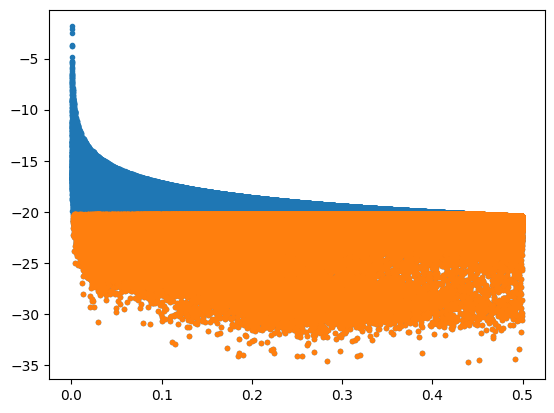

In [65]:
plt.plot(data['z'],data['M'],'.')
cond =  data['M']< -20.25
plt.plot(data['z'][cond],data['M'][cond],'.')
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

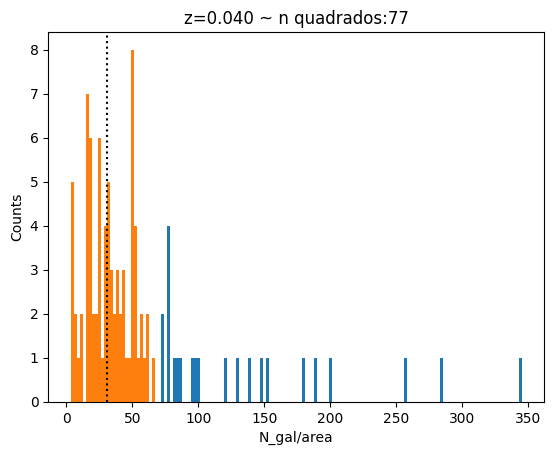

 10%|█         | 1/10 [00:03<00:29,  3.32s/it]

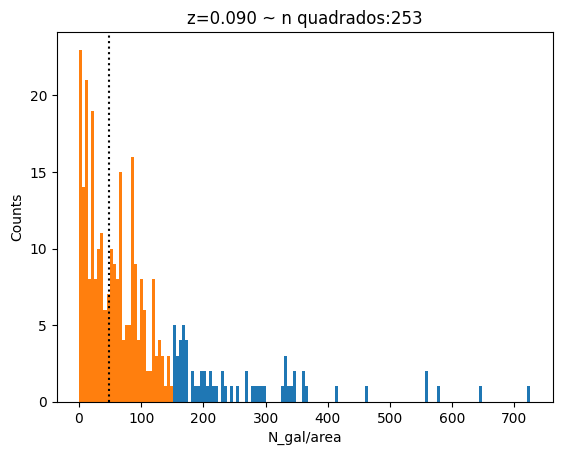

 20%|██        | 2/10 [00:07<00:30,  3.84s/it]

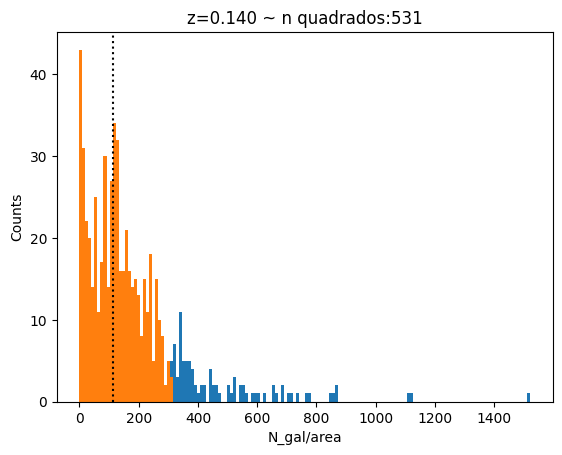

 30%|███       | 3/10 [00:14<00:38,  5.47s/it]

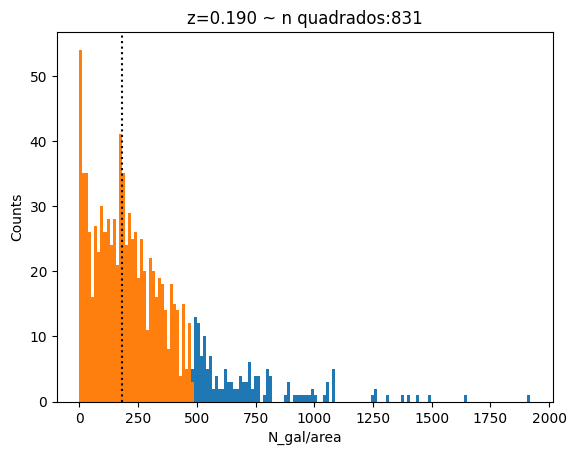

 40%|████      | 4/10 [00:23<00:40,  6.72s/it]

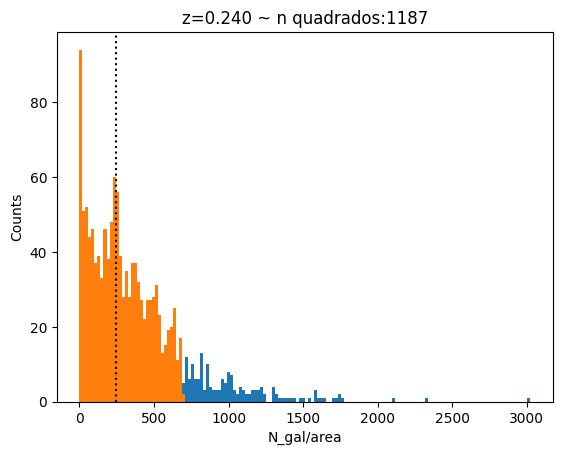

 50%|█████     | 5/10 [00:35<00:43,  8.61s/it]

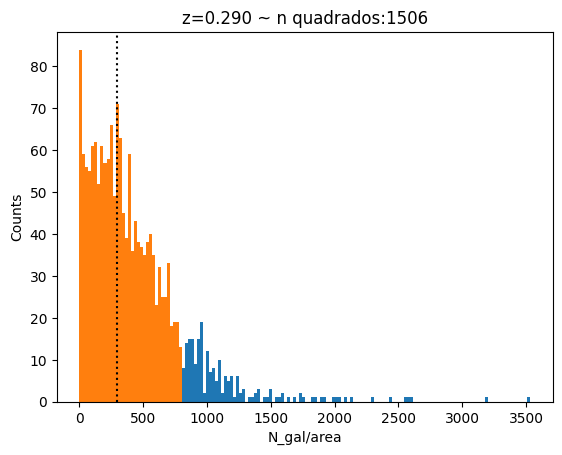

 60%|██████    | 6/10 [00:50<00:43, 10.84s/it]

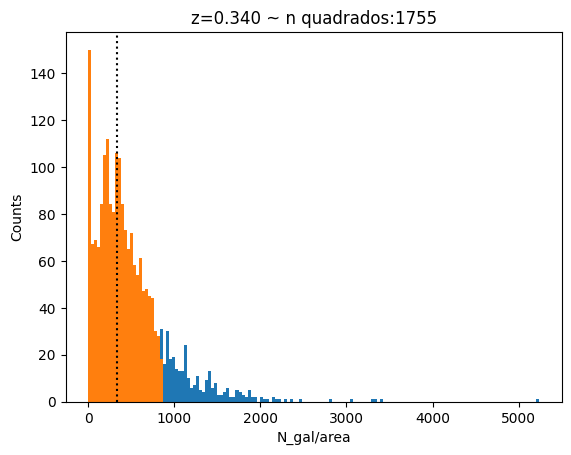

 70%|███████   | 7/10 [01:10<00:41, 13.91s/it]

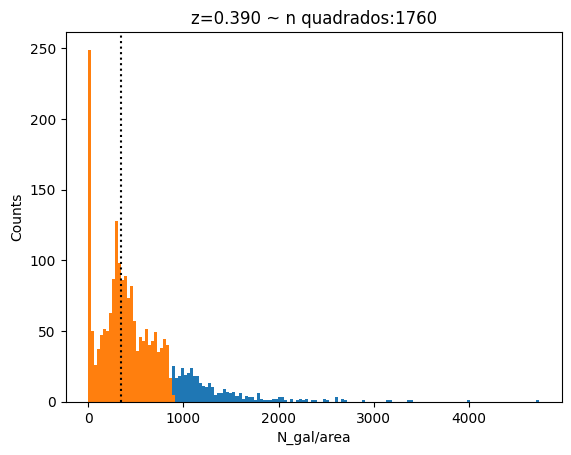

 80%|████████  | 8/10 [01:29<00:30, 15.45s/it]

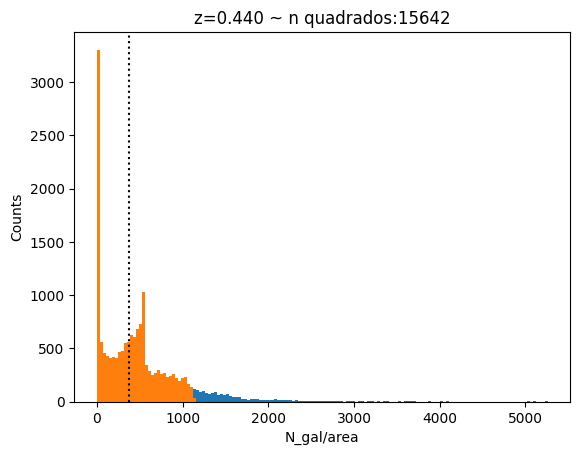

 90%|█████████ | 9/10 [03:57<00:56, 56.79s/it]

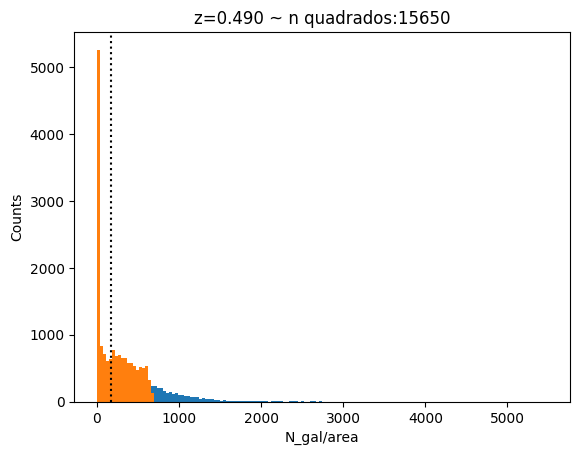

100%|██████████| 10/10 [06:36<00:00, 39.68s/it]


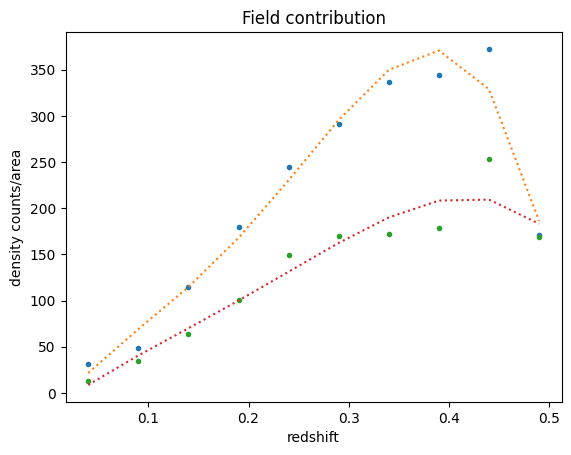

(array([-2.87674842e+01,  1.50816229e+03, -7.55411278e+03,  3.65708567e+04,
        -5.22623897e+04]),
 array([   -21.90478777,    852.36018484,  -2594.56817986,  10545.87191736,
        -14403.58498721]))

In [90]:
data2 = data[cond]
survey_area_statistics(500, data2, 'stats_20.txt')


In [81]:
# save interpolation results in a separated array
popt_mode, popt_err = (array([-2.87674842e+01,  1.50816229e+03, -7.55411278e+03,  3.65708567e+04, -5.22623897e+04]),
                       array([   -21.90478777,    852.36018484,  -2594.56817986,  10545.87191736, -14403.58498721]))

##random

Test initial configuration over a randomic catalog. Richness results should result in zero for R$_{AME}$ and oscilates within zero for R$_{FAE}$

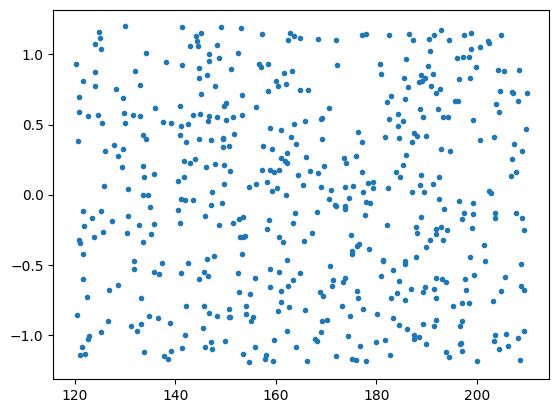

In [35]:
size = 500
zs_r = random.uniform(low=0.05, high=.45, size=size)
random_detec = random_catalog(zs_r, cluster_catalog, size = size)

# create Rc based on the cluster data
Rc = cluster_catalog['Rc']
z = linspace(min(Rc), max(Rc), 20)
random_z = []
for gal in range(size):
  #random value from distribution inside z +/- dz
  random_zi = random.choice(z, p=histogram(Rc, bins=20)[0]/sum(histogram(Rc, bins=20)[0]))
  random_z += [random_zi]

random_detec['Rc'] = random_z
random_detec['ID'] = arange(len(random_detec))

plt.plot(random_detec['ra'], random_detec['dec'], '.')
plt.show()

In [88]:
# apply mag cut
cond =  data['M']< -20.25
data2 = data[cond]
data2['l_id'] = arange(len(data2))

# initiate var -----
rich_hdbs_r = []
richs_r =[]

# run FAE and AME
for i in tqdm.tqdm(range(len(random_detec))):
  deltaz = 0.05
  # FAE richness
  rich, err, snr = richness_rv(data2, random_detec[i], deltaz, random_detec['Rc'][i], popt_mode, popt_err)
  richs_r += [rich]

  # AME richness
  # 0.5292105368716316, 0.026652401872489406 represents the linear fitting that describes
  # the best agreement between SPLUS mock true members and the one obtained from FAE
  # used to calculate minimun number of neighbours for HDBSCAN as presented below
  out_data = hbdscan_run(data2, random_detec[i], deltaz, random_detec['Rc'][i], 50, 0.5292105368716316, 0.026652401872489406, rich,
                      is_mock=0, do_plot=0)

  rich_hdbs_r += [sum(out_data['member_hdbsdcan'])]


 37%|███▋      | 185/500 [06:33<12:08,  2.31s/it]

no galaxies within Rc


100%|██████████| 500/500 [17:35<00:00,  2.11s/it]


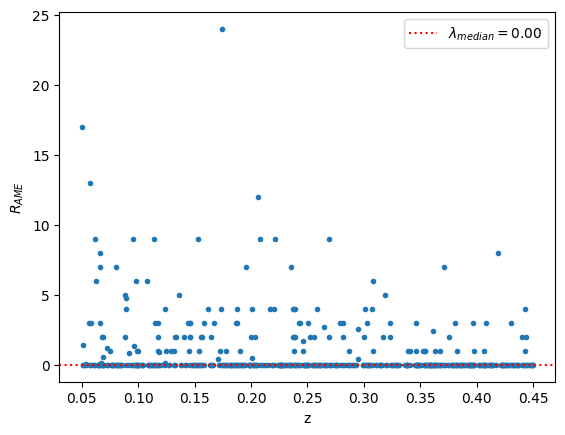

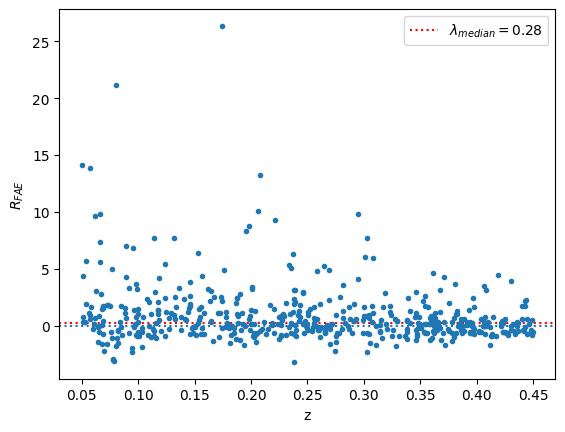

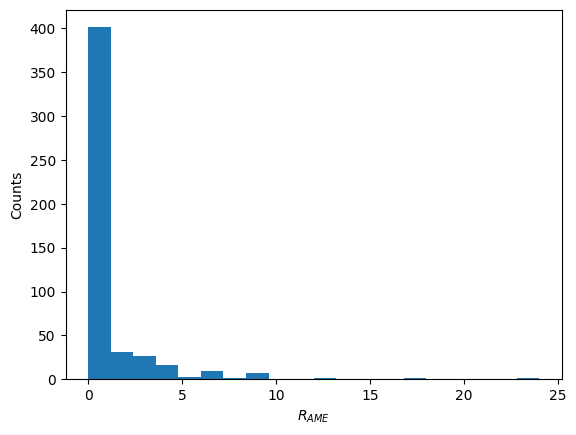

In [89]:
plt.plot(random_detec['z'], rich_hdbs_r, '.')
plt.axhline(median(rich_hdbs_r), ls=':', color ='r', label='$\lambda_{median}=%.2f$'%median(rich_hdbs_r))
plt.xlabel('z')
plt.ylabel('$R_{AME}$')
plt.legend()
plt.show()

plt.axhline(0, ls=':')
plt.axhline(median(richs_r), ls=':', color ='r', label='$\lambda_{median}=%.2f$'%median(richs_r))
plt.plot(random_detec['z'], richs_r, '.')
plt.xlabel('z')
plt.ylabel('$R_{FAE}$')
plt.legend()
plt.show()

plt.hist(rich_hdbs_r, bins=20)
plt.xlabel('$R_{AME}$')
plt.ylabel('Counts')
plt.show()

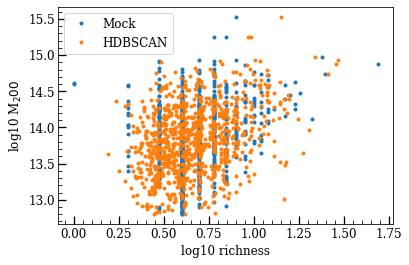

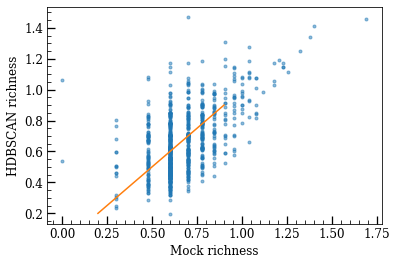

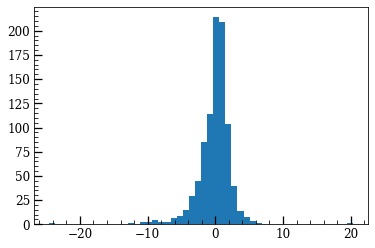

-82.3999999999998
0.1900000000000004 -0.09045005488474182
1.0699999999999994 2.407672540897214
0.018861217359339655 0.008657496487614621
0.11228290252157475 0.17251247962957292


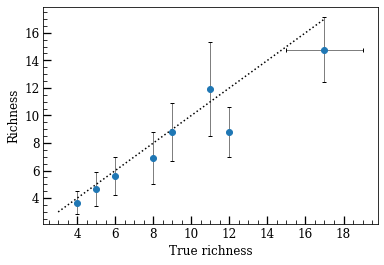

mean +/- std 0.8543750000000002 1.2118746776688594
median +/- mad 0.3600000000000003 0.44499999999999984
mean +/- std todos 0.008657496487614621 0.17251247962957292
median +/- mad todos 0.018861217359339655 0.11228290252157475


In [ ]:
# plot results comparing with mock catalog

## catalog run

In [ ]:
# load cluster catalog
cluster_catalog = Table.read('%s/cluster_catalog.fits'%path, format='fits')
cluster_catalog['ra'] = cluster_catalog['ra']
cluster_catalog['dec'] = cluster_catalog['dec']
print(cluster_catalog.columns)


<TableColumns names=('ID','RA','DEC','z','z_err','SNR','SNR_ORIG','richness','radius','rank','ra','dec')>


In [63]:
# catalog name
catalog_name = 'cluster_catalog_Rc'

# add column for Rc
cluster_catalog['Rc'] = (99.9)*len(cluster_catalog)

init = 0
#for i in tqdm.tqdm(range(init, len(cluster_catalog))):
for i in tqdm.tqdm(range(0,100)):

  # firts calculate knee radius (full galaxy data)
  outer_radius = 1500
  dz = 0.05
  data_cut = select_galaxies_data(data, cluster_catalog[i], outer_radius, dz)
  knee = radial_density_knee(data_cut, cluster_catalog[i])
  cluster_catalog['Rc'][i] = knee

  if i%500 == 0: # temporary saving
    t = Table(cluster_catalog, names=cluster_catalog.columns)
    t.write('%s/%s_%s.fits'%(path, catalog_name, init), format='fits', overwrite=True)

t = Table(cluster_catalog, names=cluster_catalog.columns)
t.write('%s/%s_%s.fits'%(path, catalog_name, init), format='fits', overwrite=True)

100%|██████████| 100/100 [15:04<00:00,  9.05s/it]


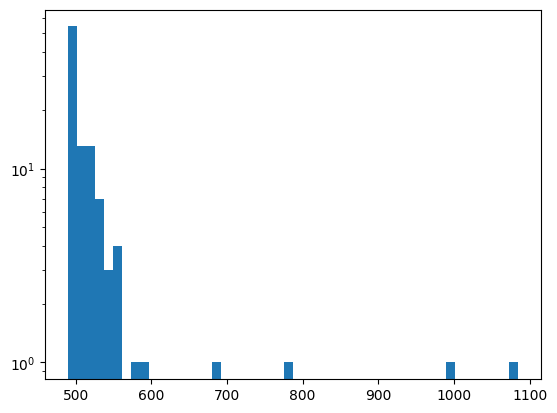

In [64]:
plt.hist(cluster_catalog['Rc'][:100], bins=50, log='true')
plt.show()

In [66]:
# Load catalog with Rc
cluster_catalog = Table.read('%s/cluster_catalog_Rc_0.fits'%path, format='fits')
catalog_name = 'cluster_catalog_final'

cluster_catalog = cluster_catalog[cond_ra & cond_dec]

# add absolute magnitude limit
cond =  data['M']< -20.25
data2 = data[cond]

# Load function parameters for field density
popt_mode, popt_err = (array([-2.87674842e+01,  1.50816229e+03, -7.55411278e+03,  3.65708567e+04, -5.22623897e+04]),
                       array([   -21.90478777,    852.36018484,  -2594.56817986,  10545.87191736, -14403.58498721]))
# run catalog
cluster_catalog = run(cluster_catalog[:100], data2, catalog_name, init=0)

"""
"no galaxies within Rc" indicates that with the given absolute magnitude limit
there is no galaxy within the characteristic radius -- happens depending on the
survey completeness.
"""

 13%|█▎        | 13/100 [04:24<27:19, 18.85s/it]

no galaxies within Rc


 18%|█▊        | 18/100 [05:54<24:19, 17.80s/it]

no galaxies within Rc


 48%|████▊     | 48/100 [14:57<15:28, 17.86s/it]

no galaxies within Rc


 68%|██████▊   | 68/100 [21:07<08:52, 16.65s/it]

no galaxies within Rc


 69%|██████▉   | 69/100 [21:22<08:22, 16.22s/it]

no galaxies within Rc


 74%|███████▍  | 74/100 [22:58<07:54, 18.24s/it]

no galaxies within Rc


 75%|███████▌  | 75/100 [23:16<07:34, 18.17s/it]

no galaxies within Rc


 84%|████████▍ | 84/100 [25:58<04:30, 16.93s/it]

no galaxies within Rc


 88%|████████▊ | 88/100 [27:07<03:26, 17.17s/it]

no galaxies within Rc


100%|██████████| 100/100 [30:30<00:00, 18.31s/it]


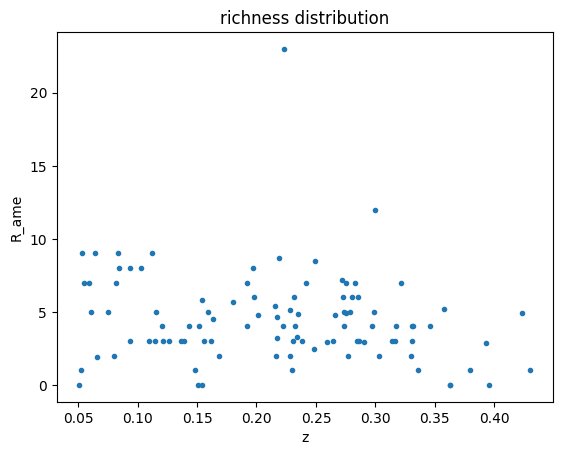

In [67]:
cluster_catalog = cluster_catalog[:100]
plt.plot(cluster_catalog['z'], cluster_catalog['R_ame'],'.')
plt.xlabel('z')
plt.ylabel('R_ame')
plt.title('richness distribution')
plt.show()

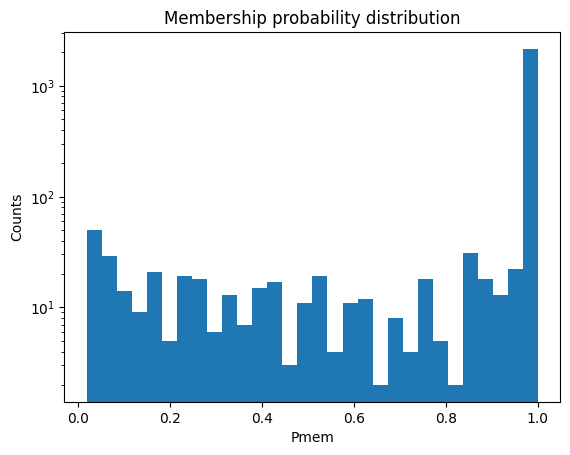

In [33]:
cond_plot = (data2['Prob']<99) & (data2['Prob']>0)
plt.hist(data2['Prob'][cond_plot], bins=30, log=True)
plt.xlabel('Pmem')
plt.ylabel('Counts')
plt.title('Membership probability distribution')
plt.show()

# Example run -- plotting with mock

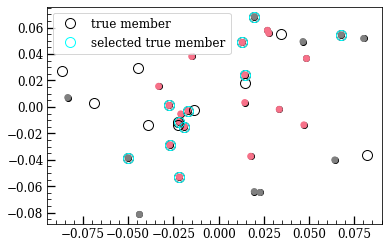

18.0 21
18.077387190268283 18.463538820997467


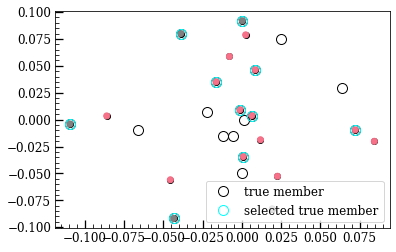

12.0 18
18.48677287361897 18.80586089853658


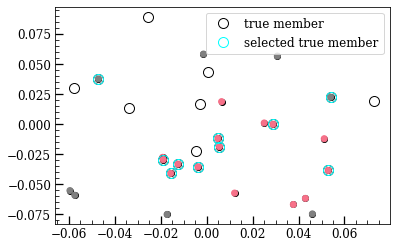

13.0 17
19.727031343780105 19.048858261156937


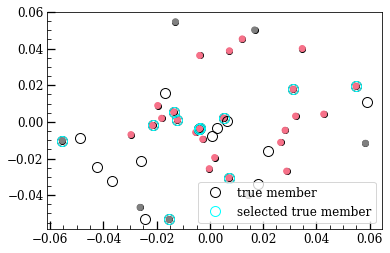

26.0 25
19.29093722752888 19.33001547558162


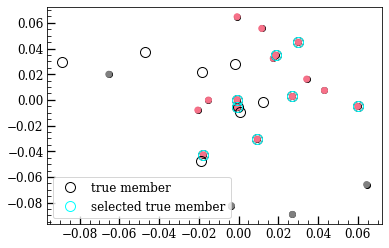

16.0 16
19.048682368749198 18.80293342364294


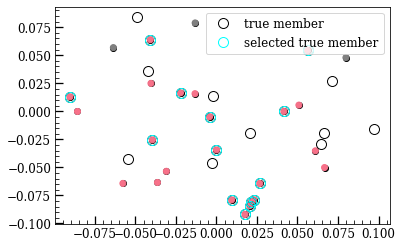

23.0 24
17.624629293575587 18.0284042286596


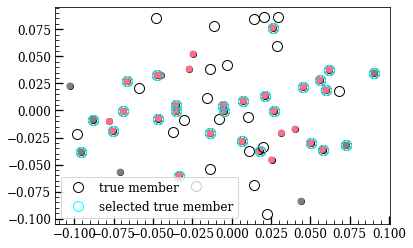

28.0 49
18.580847999354997 18.96503761868241


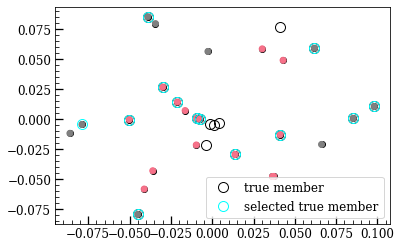

15.0 17
17.96733544049503 18.47406775107921


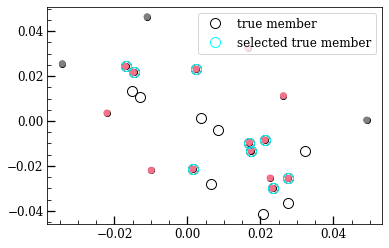

14.0 17
19.574065780591468 19.32698331839944


In [ ]:
# plotting detections with hdbscan only highlighting mock true members

cluster_catalog2 = cluster_catalog[cluster_catalog['R_ame_mock']>15]

for i in range(len(cluster_catalog2)):
  # hbdscan_run(data, cluster, dz, radius, N_runs, gradient, intercept, cluster_rich,
  #              is_mock=0, do_plot=0):
  out_data = hbdscan_run(data, cluster_catalog2[i], 0.05, cluster_catalog2['Rc'][i],
                          1, 0.5292105368716316, 0.026652401872489406, cluster_catalog2['R_fae'][i],
                          is_mock=1, do_plot=1)
